# **Assignment 1**


---







In [1]:
# Packages needed for this assignment
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# Introduction

The Environment

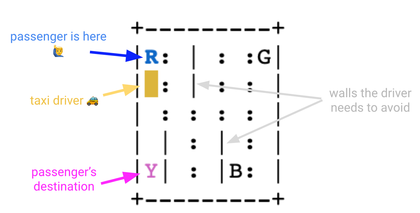




R, G, B, Y are locations on this map
The pipe symbol (|) represent walls
The colon symbol (:) represent open spaces

1.	The map is a 5x5 gridworld, leading to 25 locations.
2.	The alphabets R, G, B, Y are 4 locations.
3.	A passenger can be at any of the 4 locations.
4.	A passenger’s destination can be any of the left 3 locations.
5. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.
6.	The taxi can pass through **:** but not **|**
7.	The colon symbol **:** denotes a pass, which means, |B:a| if you’re at position **a** you can get to position **B** by going left.
8.	The pipe symbol **|** denotes a wall, which means, |Y|x: if you’re at position **x** you can’t get to position **Y** by going left.
9.	The environment rewards 20 points when a passenger is dropped to their destination.
10.	The environment penalizes -10 points if pickup operation is performed on a cell where there is no passenger.
11.	The environment penalizes -10 points if drop operation is performed if no passenger had boarded the taxi.
12.	The environment penalizes -1 for every other action.
13.	There are 500 states in this environment.

Each state answers these questions:
1.	Where is the taxi right now (one out of the 25 cells).
2.	Where is the passenger right now (one out of R,G,B,Y and the possibility of being inside the taxi).
3.	Where does the passenger want to go (one out of R,G,B,Y).

Initial conditions:
1.	At the start, the taxi will be at any of the 25 positions on the map.
2.	A passenger will be at any of R, G, B, Y locations.
3.	A destination will be at any of the R, G, B, Y locations.

Agent — Taxi

Our agent is a taxi, which can perform 6 actions:
0.	South
1.	North
2.  West
3.	East
4.	Pickup
5.	Dropoff

Expected behaviour

1.	The taxi must find the passenger traveling the shortest path.
2.	The taxi must pickup the passenger.
3.	The taxi must find the shortest path to the passenger’s destination.
4.	Drop the passenger at their destination traversing the shortest path


# Getting started with Open AI gym

[OpenAI Gym](http://gym.openai.com) is a toolkit for comparing RL-algorithms. It contains a wide variety of environments that you can train your agents on, and it is often used for benchmarking new methods in the RL research litterature. 
There are also [leaderboards](https://github.com/openai/gym/wiki/Leaderboard) for different gym-environments, showing which methods has been most successful so far.

In the assignments for this course we will make use of OpenAI gym (within the course's scope).

To test your installation of OpenAI gym, and learn about basic usage, we will look at the relatively simple Taxi-environment.

## Taxi driver - demo
In **this** environment there are four locations. Your job is to pick up a passenger at one of these locations, and then drop her of at another location. 

To test this environment run the following lines of code.

In [2]:
env = gym.make('Taxi-v3').env
state = env.reset()
print('Initial state:', state)

Initial state: 128


/Users/maroon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The methods used above are:
* `make()`: Creates a gym environment object. In this case we use the Taxi-environment.
* `reset()`: Resets the environment to an initial state, and returns the initial state. 
In the case of the Taxi-environment, the initial state is chosen randomly, so it will be different every time you run `env.reset()`.

To visualize the current state of the environment, you can use the function `render()`. In the Taxi-environment the visualization is text-based. 

In [3]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [66]:
env.unwrapped.s = 345
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


The filled square represents the taxi, the letters (R, G, Y and B) represents possible pickup and destination locations, and | represents a wall. The blue letter is the passenger, and the purple is the destination.

Next we take a look at the state space $\mathcal{S}$ (all possible states) and action space $\mathcal{A}$ (all possible actions). 

In [ ]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))


***Remark***: You may have noticed that gym uses `observation_space` instead of state space. For the purpose of this homework, the state space is the same as the observations space. However, in some problems the full state cannot be observed, so the space of possible states may not be the same as the space of possible observations. 

We next see how the agent can interact with the environment.

In [ ]:
new_state, reward, done, info = env.step(1) # Take action 1 (north)
env.render()
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)

If it was possible, the taxi should now have moved one step north (if the taxi started at the top row then it will not move). The step-function returns the following information:
* __New state__: The state after the action is taken.
* __Reward__: The immediate reward. In the taxi-environment the reward for illegal "pickup" or "dropoff" is -10, successfully delivering the passenger gives +20, and any other action gives -1.
* __Done__: Is the environment done? In the Taxi-environment this will be false until the passenger is successfully dropped at her destination, or the number of actions taken gets larger than 200.
* __info__: Additional information mainly used for debugging.

The goal of the agent is thus to deliver the passanger to her destination in as few steps as possible. If more than 200 actions are taken, the agent has failed. 

One (quite bad) strategy for the taxi problem is to take a random action every time. Inside a gym-environment this can be done using `env.action_space.sample()`, which samples a random action from the action space. Look through the following loop and make sure that you understand what's going on. (We here use `clear_output()` to clear the output of the Jupyter cell, and `time.sleep()` to pause between each action)


Let's see what would happen if we try to brute-force our way to solving the problem.

Since we have our P table for default rewards in each state, we can try to have our taxi navigate just using that.

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20. The env.action_space.sample() method automatically selects one random action from set of all possible actions.

In [18]:
def randomAgent(start_state):
  env.s = start_state # set environment to illustration's state
  epochs = 0
  penalties, reward = 0, 0

  frames = [] # for animation
  visited = []
  rewards = 0
  done = False
  while not done:
      action = env.action_space.sample()
      state, reward, done, info = env.step(action)
      
      while state in visited:
        action = env.action_space.sample()
        
        state, reward, done, info = env.step(action)
      
      visited.append(state)
      rewards += reward
      if reward == -10:
          penalties += 1
      
      # Put each rendered frame into dict for animation
      frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
      )
      

      epochs += 1
  return (frames,rewards)

 

frames,reward = randomAgent(328)
print("Reward incurred: {}".format(reward))

Reward incurred: 6


Printing created frames:

Note: we will be using this code to test your outputs

In [3]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(0.4)

In [4]:
print(tuple(env.decode(79)))

(0, 3, 4, 3)


In [19]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 6
State: 0
Action: 5
Reward: 20


As you can see, random actions is, unsurprisingly, not a good policy. However, what else can we do?

This is where you come in!

In this assignment you will be required to implement the following algorithms taught in class inorder to solve the problem.

Algorithms: 
1. Breadth First Search
2. Depth First Search
3. ID-DFS
4. W-A*
5. A* epsilon

Important to note!
*   Each agent should recive **state 328** as the initial state
*   Each agent should return a tuple: (frames,reward) 
1.   Frames: list of frames which would be able to be printed using the "print_frames" function which you were given.
2.   Reward: an integer which holds the total reward of the optimal (shortest) path



> For example, we will **test** your BFS agent code using the lines:
```
env.s = 328
frames,reward = bfs(env.s)
print_frames(frames)
print(reward)
```

*   Any other submision of code will cause the running of the notebook to fail and will result in a grade of 0 !



Some Tips (may be updated):
1. Folow the pseudo-code shown in the lectures this will help you greatly
2. Think about implementing a "node" class either a generic one or a different one for each search agent.
For example:
```
# BFS node:
class BFSNode:
        def __init__(self, frame=None, state=None, action=None, reward=None):
            self.frame = frame
            self.state = state
            self.action = action
            self.reward = reward


3. Think about implementing a "getNeighbours" function
For example:
```
def getNeigbours(node):
      env.s = node.state
      neighbours = []
      for action in range(6):
        new_state, reward, done, info = env.step(action) # Take action i
        new_node = (env.render(mode='ansi'),new_state,action,reward)
        neighbours.append(new_node)
        env.s = node.state
      return neighbours


4. Read the whole document before coding, this will help you plan ahead and cause less headaches in advance 


# Utility Functions

In [15]:
def make_node(state, action, reward):
    return {
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }

# trace_back receives a state -> node mapping, state -> parent state mapping and the final state.
# returns a tuple of nodes array of the traced-back path from first_state -> final_state (frames), and the accumulated reward.
def trace_back(state_to_node, state_to_parent_state, final_state):
    parent_state = state_to_parent_state[final_state]

    frames = [state_to_node[final_state]]  # frames is not a good name, but that's what you (staff) used
    reward = state_to_node[final_state]['reward']

    while parent_state != -1:  # loop until first state
        current_node = state_to_node[parent_state]
        parent_state = state_to_parent_state[parent_state]
        
        if parent_state == -1:
            break # don't add initial state into frames (only the action after it)
            
        frames.insert(0, current_node)
        reward += current_node['reward']

    return frames, reward

# getNeighbors receives a node and returns a tuple of (neighboring nodes, done).
# if one of the neighbors is the final state, then it would be the last.
def get_neighbors(env, node, neighborsCheckStep=1):
    env.unwrapped.s = node['state']

    neighbours = []
    done = False

    for action in range(6)[::neighborsCheckStep]:
        new_state, reward, done, info = env.step(action)  # Take action i
        new_node = make_node(new_state, action, reward)
        neighbours.append(new_node)
        env.unwrapped.s = node['state']

    return neighbours, done

## 1. BFS
In this section please implement Breadth First Search like shown in class


In [42]:
bfs_counter = 0

In [43]:
class BFSRunner:
    def run(self, env, first_state):
        env.s = first_state

        first_node = make_node(first_state, -1, 0)
        queue = [first_node]

        closed_nodes = {}  # key: state, val: True
        open_nodes = {first_state: True}

        state_to_node = {first_state: first_node}  # map state -> node for traceback
        state_to_parent_state = {first_state: -1}  # map state -> predecessor state

        while len(queue) != 0:
            next_node = queue.pop(0)  # get node from queue
            open_nodes.pop(next_node['state'])
            
            global bfs_counter
            bfs_counter += 1
            
            closed_nodes[next_node['state']] = True  # mark as closed
            
            # get neighbors
            neighbors, done = get_neighbors(env, next_node)
            if done:  # last neighbor is a final state
                state_to_node[neighbors[-1]['state']] = neighbors[-1]
                state_to_parent_state[neighbors[-1]['state']] = next_node['state']  # map state -> parent state
                return trace_back(state_to_node, state_to_parent_state, neighbors[-1]['state'])


            for node in neighbors:
                # check if visited
                if open_nodes.get(node['state']) is not None or closed_nodes.get(node['state']) is not None:
                    continue  # already in open or has been closed

                # safe to map state -> node since wont be overwritten (due to the above checks)
                state_to_node[node['state']] = node
                state_to_parent_state[node['state']] = next_node['state']  # map state -> parent state

                queue.append(node)  # add to queue
                open_nodes[node['state']] = True
                
        return [], None

In [44]:
# use the algorithm learnt in class
# should return (frames,reward)

def bfs(first_state):
    return BFSRunner().run(env, first_state)

# driver code - for your use only, do not submit these lines!
env.s = 328
frames,reward = bfs(env.s)
#print_frames(frames)
#print(reward)
bfs_counter

31

## 2. DFS
In this section please implement Depth First Search like shown in class


In [45]:
dfs_counter = 0

In [46]:
class DFSRunner:
    def run(self, env, first_state):
        env.unwrapped.s = first_state

        first_node = make_node(first_state, -1, 0)
        stack = [(first_node, -1)] # stack of tuple(node, parent_state)

        closed_nodes = {}  # key: state, val: True

        state_to_node = {first_state: first_node}  # map state -> node for traceback
        state_to_parent_state = {first_state: -1}  # map state -> predecessor state

        while len(stack) != 0:
            current_node, parent_state = stack.pop(-1)  # get node from stack
            if closed_nodes.get(current_node['state']) is not None:
                    continue  # already has been closed
            
            print(current_node['frame'])
            
            state_to_parent_state[current_node['state']] = parent_state # restore parent to info in stack
            closed_nodes[current_node['state']] = True  # mark as closed

            # get neighbors
            neighbors, done = get_neighbors(env, current_node, -1)

            if current_node['reward'] == 20:  # last neighbor is a final state
                return trace_back(state_to_node, state_to_parent_state, current_node['state'])
                
            global dfs_counter
            dfs_counter += 1
            
            for node in neighbors:
                # check if visited
                if closed_nodes.get(node['state']) is not None:
                    continue  # already has been closed

                state_to_node[node['state']] = node
                stack.append((node, current_node['state']))  # add to stack
            
        return [], None

In [47]:
# use the algorithm learnt in class
# should return (frames,reward)

def dfs(first_state):
      return DFSRunner().run(env, first_state)


# driver code - for your use only, do not submit these lines!
env.s = 328
frames,reward = dfs(env.s)
print_frames(frames)
print(reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 18
State: 0
Action: 5
Reward: 20
3


In [48]:
dfs_counter

100

## 3. ID-DFS
In this section please implement Iterative Deepening Depth First Search like shown in class

In [54]:
dfsl_counter = 0
state_set = {}
depth_to_nodes = {}

In [55]:
class DFSLRunner:
    def __init__(self, l):
        self.l = l

    def run(self, env, first_state):
        env.unwrapped.s = first_state

        first_node = make_node(first_state, -1, 0)
        stack = [(first_node, -1, 0)] # stack of tuple(node, parent_state, depth)

        closed_nodes = {}  # key: state, val: minimal visited depth

        state_to_node = {first_state: first_node}  # map state -> node for traceback
        state_to_parent_state = {first_state: -1}  # map state -> predecessor state
        
        while len(stack) != 0:
            current_node, parent_state, current_depth = stack.pop(-1)  # get node from stack
                
            if closed_nodes.get(current_node['state']) is not None and \
                closed_nodes[current_node['state']] <= current_depth:
                continue  # already has been closed
                    
            # save parent info
            state_to_parent_state[current_node['state']] = parent_state
            
            if current_depth >= self.l:
                continue
                
            closed_nodes[current_node['state']] = current_depth

            if current_node['reward'] == 20:
                return trace_back(state_to_node, state_to_parent_state, current_node['state'])

            global dfsl_counter, state_set, depth_to_nodes
            # counter
            dfsl_counter += 1
            # unique counter
            if state_set.get(current_node['state']) is None:
                state_set[current_node['state']] = True
            # depth to node
            depth_to_nodes[self.l] += 1
            
            # get neighbors
            neighbors, _ = get_neighbors(env, current_node, -1)
            
            for node in neighbors:
                # check if visited at same depth
                if closed_nodes.get(node['state']) is not None and \
                    closed_nodes[node['state']] <= current_depth + 1:
                    continue  # already has been closed at this depth

                state_to_node[node['state']] = node
                # add to stack (node, parent, depth)
                stack.append((node, current_node['state'], current_depth + 1))

        return [], None

In [56]:
# use the algorithm learnt in class
# think about how to use dfs() foor your solution
# should return (frames,reward)

def id_dfs(first_state, depth):
    for l in range(depth):
        depth_to_nodes[l] = 0
        frames, reward = DFSLRunner(l).run(env, first_state)
        
        if reward is not None:
            return frames, reward
 
    return [], None



# driver code - for your use only, do not submit these lines!
env.s = 328
initial_depth = 19 # random depth
frames,reward = id_dfs(env.s, initial_depth)
#print_frames(frames)
#print(reward)
print('unique', len(state_set), 'counter', dfsl_counter)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 10
State: 0
Action: 5
Reward: 20
11
unique 35 counter 393


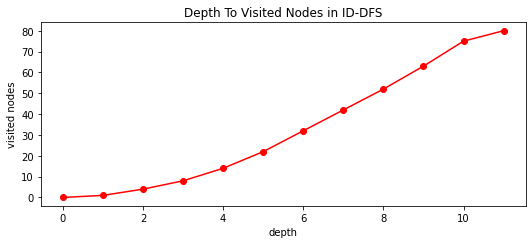

In [57]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
ax1.set_xlabel("depth")
ax1.set_ylabel("visited nodes")
ax1.set_title("Depth To Visited Nodes in ID-DFS")

x = depth_to_nodes.keys()
y = [depth_to_nodes[key] for key in x]

r, = ax1.plot(x, y, marker = 'o', color="red")
plt.show()
    

## 4. W-A*
In this section please implement W-A* like shown in class

In [63]:
import heapq

def make_star_node(state, action, reward, g_val, h_val, w):
    return starNode(state, action, reward, g_val, h_val, w)

def convert_to_star_node(node, g_val, h_val, w):
    return starNode(None, None, None, g_val, h_val, w, node)

def queue_put_star_node(q, star_node):
    heapq.heappush(q, star_node)
    
def queue_replace_node(q, star_node):
    # delete node from list
    for idx, item in enumerate(q):
        if item.get_state() == star_node.get_state():
            del q[idx]
    # restore queue invariant        
    heapq.heapify(q)
    # add the node again
    queue_put_star_node(q, star_node)
    
class starNode:
    def __init__(self, state, action, reward, g_val, h_val, w, node=None):
        if node is None:
            self.node = make_node(state, action, reward)
        else:
            self.node = node
            
        self.g = g_val
        self.h = h_val
        self.f = (-1 * w[0]*g_val) + w[1]*h_val
    
    def get_state(self):
        return self.node['state']

    def done(self):
        return self.node['reward'] == 20
    
    def __lt__(self, other):
        return self.f <= other.f
    
    
frames = []

In [69]:
class AStarRunner:
    def __init__(self, h_func, weight, epsilon, pop_func):
        self.h_func = h_func
        # w = [g weight, h weight]
        self.w = [1 - weight, weight]
        self.epsilon = epsilon
        
        # pop_func receives a priority queue, epsilon and POPS the "focal" minimum from it
        self.pop_func = pop_func
        

    def run(self, env, first_state):
        env.s = first_state

        first_star_node = make_star_node(state=first_state, action=-1, reward=0, \
                                         g_val=0, h_val=self.h_func(first_state), w=self.w)

        prio_queue = []
        queue_put_star_node(prio_queue, first_star_node)

        # in here open_nodes / closed_nodes map state -> star_node for convenience
        open_star_nodes = {first_state: first_star_node}
        closed_star_nodes = {}

        state_to_node = {first_state: first_star_node.node}  # map state -> node for traceback
        state_to_parent_state = {first_state: -1}  # map state -> predecessor state

        while len(prio_queue) != 0:
            current_star_node = self.pop_func(prio_queue, self.epsilon)  # get node from priority queue
            open_star_nodes.pop(current_star_node.get_state())

            global a_star_counter
            a_star_counter += 1
            
            closed_star_nodes[current_star_node.get_state()] = current_star_node  # mark as closed
            
            if current_star_node.done():  # current node is a final state
                if current_star_node.get_state() >= 500: # special scenario described below
                    state_to_node[current_star_node.get_state()]['state'] -= 500 # restore internal node state
                    
                return trace_back(state_to_node, state_to_parent_state, current_star_node.get_state())

            # get neighbors
            neighbors, _ = get_neighbors(env, current_star_node.node)

            for node in neighbors:
                new_g = current_star_node.g + node['reward']
                
                if node['reward'] == 20 and \
                    closed_star_nodes.get(node['state']) is not None: # node already visited
                    # special scenario where the passenger is located at the drop-off spot
                    node['state'] += 500
                    
                # check if not seen yet
                if open_star_nodes.get(node['state']) is None and closed_star_nodes.get(node['state']) is None:
                    new_star_node = convert_to_star_node(node=node, \
                                                         g_val=new_g, h_val=self.h_func(node['state']), w=self.w)

                    queue_put_star_node(prio_queue, new_star_node)
                    open_star_nodes[node['state']] = new_star_node

                # check if in open and needs updating
                elif open_star_nodes.get(node['state']) is not None and \
                    new_g > open_star_nodes[node['state']].g:
                    # replace node in prio_queue (by state) 
                    new_star_node = convert_to_star_node(node=node, \
                                                         g_val=new_g, h_val=self.h_func(node['state']), w=self.w)

                    queue_replace_node(prio_queue, new_star_node)
                    open_star_nodes[node['state']] = new_star_node
                    
                # check if in closed and needs updating                        
                elif closed_star_nodes.get(node['state']) is not None and \
                    new_g > closed_star_nodes[node['state']].g:
                    # insert to open nodes
                    new_star_node = convert_to_star_node(node=node, \
                                                         g_val=new_g, h_val=self.h_func(node['state']), w=self.w)

                    queue_put_star_node(prio_queue, new_star_node)
                    open_star_nodes[node['state']] = new_star_node
                    # remove from closed nodes
                    closed_star_nodes.pop(node['state'])
                    
                else:
                    continue
                    
                # safe to map state -> node since wont be overwritten (due to the above checks)
                state_to_node[node['state']] = node
                state_to_parent_state[node['state']] = current_star_node.get_state()  # map state -> parent state

        return [], None

In [70]:
def manhattan_distance_to_destination(r, c, dest_idx):
    dest_idx_to_location = {
        0: (0,0),
        1: (0,4),
        2: (4,0),
        3: (4,3),
        4: (r,c),
    }
    
    return abs(dest_idx_to_location[dest_idx][0] - r) + \
        abs(dest_idx_to_location[dest_idx][1] - c)

In [108]:
def bad_h(state):
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
    
    return 50 + (4 - taxi_col + taxi_row)

def md_taxi_dest(state):
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
    return taxi_row - env.locs[dest_idx][0] + taxi_col - env.locs[dest_idx][1]

def inadmissible_but_good(state):
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
    
    dest_idx_to_bad_location = {
        0: (0,1),
        1: (1,4),
        2: (4,1),
        3: (4,4),
    }
    
    return taxi_row - dest_idx_to_bad_location[dest_idx][0] + \
        taxi_col - dest_idx_to_bad_location[dest_idx][1]

def greedy_h(state):
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
    return not pass_loc == dest_idx
    
def manhattan_sum_h(state):      
    # chose option 2
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
    
    # if passenger is in taxi, return MD(taxi-loc, destination)
    if pass_loc == 4:
        return manhattan_distance_to_destination(taxi_row, taxi_col, dest_idx)
    
    # otherwise,
    pass_row, pass_col = env.locs[pass_loc]
    return manhattan_distance_to_destination(taxi_row, taxi_col, pass_loc) + \
        manhattan_distance_to_destination(pass_row, pass_col, dest_idx)

global_pickup_loc = -1
def pickup_mult_h(state):
    taxi_row, taxi_col, pass_loc, dest_idx = tuple(env.decode(state))
         
    global global_pickup_loc
    if global_pickup_loc == -1:
        global_pickup_loc = pass_loc
        
    pickup_row, pickup_col = env.locs[global_pickup_loc]
    return (manhattan_distance_to_destination(taxi_row, taxi_col, global_pickup_loc)* \
            manhattan_distance_to_destination(pickup_row, pickup_col, dest_idx)) / \
                25

In [72]:
# use the algorithm learnt in class
# think about first impelmenting A*, check your solotion and then move on to A*
# note the heurisitcs needed to be implemented (instructions in dry pdf)
# should return (frames,reward)
def null_h(state):
    return 0

def chosen_h(state):
    return manhattan_sum_h(state)

def weighted_a_star(first_state,weight,heuristic_function):
    def heapq_pop(prio_queue, epsilon):
        return heapq.heappop(prio_queue)
    
    return AStarRunner(heuristic_function, weight, 0, heapq_pop).run(env, first_state)

# driver code - for your use only, do not submit these lines!
env.s = 328
weight = 1   # you will need to change this during the excersize 
frames,reward = weighted_a_star(env.s,weight,chosen_h)
#print_frames(frames)
#print(reward)

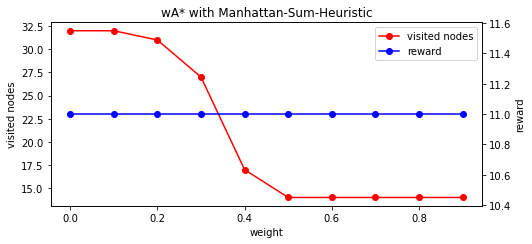

In [73]:
a_star_counter = 0
import numpy as np

def generate_graph():
    x = []
    y_reward = []
    y_visted_nodes = []
    
    for w in np.arange(0.0, 1.0, 0.1):
        global a_star_counter
        a_star_counter = 0
        
        env.s = 328
        _,reward = weighted_a_star(env.s,w,chosen_h)
        
        x.append(w)
        y_reward.append(reward)
        y_visted_nodes.append(a_star_counter)
       
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    ax1 = plt.subplot()
    ax1.set_xlabel("weight")
    ax1.set_ylabel("visited nodes")
    ax1.set_title("wA* with Manhattan-Sum-Heuristic")
    ax2 = ax1.twinx()
    ax2.set_ylabel("reward")
    
    r, = ax1.plot(x, y_visted_nodes, marker = 'o', color="red")
    b, = ax2.plot(x, y_reward, marker = 'o', color="blue")
    
    plt.legend([r, b], ["visited nodes", "reward"])
    
    plt.show()
    
generate_graph()

In [74]:
import sys

def pop_focal_min(prio_queue, epsilon):
    if len(prio_queue) == 0:
        return None
    
    # get min from queue - SHOULD PUSH BACK IF NOT USED
    min_star_node = heapq.nsmallest(1, prio_queue)[0]
    
    focal_min_h = sys.maxsize
    focal_min_index = 0
    
    focal_f = (1 + epsilon) * min_star_node.f
    
    for i, star_node in enumerate(prio_queue):
        if star_node.f <= focal_f and star_node.h < focal_min_h:
            focal_min_h = star_node.h
            focal_min_index = i

    min_star_node = prio_queue[focal_min_index]
    
    # pop the focal min and heapify queue
    del prio_queue[focal_min_index]       
    heapq.heapify(prio_queue)
    
    return min_star_node  

## 5. A*-epsilon
In this section please implement A*-epsilon like shown in class

In [75]:
# use the algorithm learnt in class
# note the heurisitcs needed to be implemented (instructions in dry pdf)
# should return the frames like in random agent

def admissible_h(state):
    return manhattan_sum_h(state)

def non_admissible_h(state):
    return bad_h(state)

def a_star_epsilon(first_state, weight, heuristic_function, epsilon):
    return AStarRunner(heuristic_function, weight, epsilon, pop_focal_min).run(env, first_state)


# driver code - for your use only, do not submit these lines!
env.s = 328
weight = 0.5   # you will need to change this during the excersize 
epsilon = 3   # you will need to change this during the excersize

frames,reward = a_star_epsilon(env.s,weight,admissible_h, epsilon)
print_frames(frames)
print(reward)

"""
frames,reward = frames = a_star_epsilon(env.s,weight,non_admissible_h,epsilon )
print_frames(frames)
print(reward)
"""

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 12
State: 0
Action: 5
Reward: 20
9


'\nframes,reward = frames = a_star_epsilon(env.s,weight,non_admissible_h,epsilon )\nprint_frames(frames)\nprint(reward)\n'

<ipython-input-112-2b4b46786144>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot()


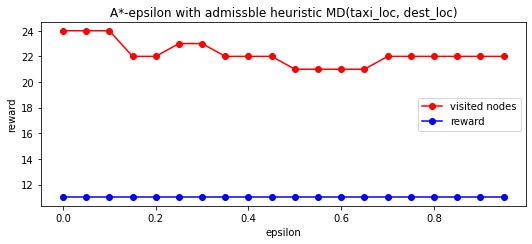

In [112]:
a_star_counter = 0
import numpy as np

def generate_graph():
    x = []
    y_reward = []
    y_visted_nodes = []
    
    for eps in np.arange(0.0, 1.0, 0.05):
        global a_star_counter
        a_star_counter = 0
        
        env.s = 328
        _,reward = a_star_epsilon(env.s,0.5,md_taxi_dest,eps)
        
        x.append(eps)
        y_reward.append(reward)
        y_visted_nodes.append(a_star_counter)
       
    plt.rcParams["figure.autolayout"] = True

    ax1 = plt.subplot()
    ax1.set_xlabel("epsilon")
    ax1.set_ylabel("visited nodes")
    ax1.set_title("A*-epsilon with admissble heuristic MD(taxi_loc, dest_loc)")
    ax2 = plt.subplot()
    ax2.set_ylabel("reward")
    
    r, = ax1.plot(x, y_visted_nodes, marker = 'o', color="red")
    b, = ax2.plot(x, y_reward, marker = 'o', color="blue")
    
    plt.legend([r, b], ["visited nodes", "reward"])
    
    plt.show()
    
generate_graph()